On the sdf login node
```
[youtsumi@sdf-login02 u]$ source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_51/loadLSST.bash                                                                                                        [89/89]
(lsst-scipipe-0.7.0-ext) [youtsumi@sdf-login02 u]$ setup lsst_distrib
(lsst-scipipe-0.7.0-ext) [youtsumi@sdf-login02 u]$ jupyter lab
```

Needs an ssh tunnel in a separate window

In [1]:
! eups list -s lsst_distrib

   22.0.1-3-g7ae64ea+78f87bf5bb 	w_latest w_2021_51 current setup


In [2]:
import sys
sys.path.append("/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/youtsumi/202112/mixcoatl/python")

In [3]:
import numpy
import pylab as plt

# Stack imports
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.meas.extensions.shapeHSM
import lsst.afw.image as afwImage
from lsst.ip.isr.isrTask import IsrTask
from mixcoatl.characterizeSpots import CharacterizeSpotsTask
from mixcoatl.gridFitTask import GridFitTask

/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/youtsumi/202112/mixcoatl/python/mixcoatl/characterizeSpots.py:136: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def run(self, exposure, exposureIdInfo=None):


In [4]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

In [5]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/"
butler = Butler(repo_path)

In [17]:
collections="LSSTCam/raw/all,u/youtsumi/Run5/run_R21_S02/spot".split(",")
butler = Butler(repo_path,collections=collections)
registry = butler.registry

In [18]:
print(registry)

PostgreSQL@rubin:bot_data_w_2021_43


In [19]:
butler = Butler(repo_path)
registry = butler.registry
for c in registry.queryCollections():
    print(c)    

LSSTCam/calib
LSSTCam/calib/unbounded
LSSTCam/raw/all
LSSTCam/photodiode/all
u/snyder18/crosstalk_13169/sbias
u/snyder18/crosstalk_13169/sbias/20211215T191900Z
u/snyder18/crosstalk_13169/calib
u/snyder18/crosstalk_13169/crosstalk_spot
u/snyder18/crosstalk_13175/sbias
u/snyder18/crosstalk_13175/sbias/20211217T211636Z
u/snyder18/crosstalk_13186/sbias
u/snyder18/crosstalk_13186/sbias/20211217T225138Z
u/snyder18/crosstalk_13175/calib
u/snyder18/crosstalk_13169/crosstalk_spot/20211218T003408Z
u/snyder18/crosstalk_13175/crosstalk_spot
u/snyder18/crosstalk_13186/calib
u/snyder18/crosstalk_13175/crosstalk_spot/20211218T225100Z
u/snyder18/crosstalk_13186/crosstalk_spot
u/snyder18/crosstalk_13186/crosstalk_spot/20211220T023605Z
u/snyder18/crosstalk_13198/sbias
u/snyder18/crosstalk_13198/sbias/20211220T182307Z
u/snyder18/crosstalk_13198/calib
u/snyder18/crosstalk_13200/sbias
u/snyder18/crosstalk_13200/sbias/20211220T215856Z
u/snyder18/crosstalk_13200/calib
u/snyder18/crosstalk_13200/crosstalk_spo

In [21]:
# then explore the inside of the collection
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

0 DatasetType('camera', {instrument}, Camera, isCalibration=True)
3144781 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('photodiode', {band, instrument, physical_filter, exposure}, AstropyTable)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
700 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
0 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
1 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
1 DatasetType('packages', {}, Packages)
0 DatasetType('cpCrosstalkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('crosstalkBackgroundZOffsets', {band, instrument, detector, physical_filter, exposure}, StructuredDataDict)
0 DatasetType('crosstalkBackgroundYTilts', {band, instru

In [26]:
where = """
instrument='LSSTCam'
and detector=83
"""
#and exposure.observation_type = 'spot'
#and exposure.science_program IN ('13232','13234')

datasetRefs = list(subregistry.queryDatasets(
    datasetType="gridSpotSrc",
    collections=collections,
    where=where)
                  )
results = []

for aref in datasetRefs[:]:
    try:
        # get a catalog from the butler
        src = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        raw = subbutler.get("raw",dataId=aref.dataId)
        img = raw.getImage().getArray()
        md = raw.getMetadata()
        # stores into memory for later use
        results.append( {"md": md, "src":src} )
    except:
#        raise
        pass

/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211224/MC_C_20211224_002073/MC_C_20211224_002073_R21_S02.fits(MC_C_20211224_002073): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211224/MC_C_20211224_002073/MC_C_20211224_002073_R21_S02.fits: DETSEC doesn't match ((minimum=(0, 2002), maximum=(511, 4003)) != (minimum=(0, 0), maximum=(511, 2001)))
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211224/MC_C_20211224_002074/MC_C_20211224_002074_R21_S02.fits(MC_C_20211224_002074): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211224/MC_C_20211224_002074/MC_C_20211224_002074_R21_S02.fits: DETSEC doesn't match ((minimum=(0, 2002), maximum=(511, 4003)) != (minimum=(0, 0), maximum=(511, 2001)))
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211224/MC_C_20211224_002075/MC_C_20211224_002075_R21_S02.fits(MC_C_20211224_002075): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211224/MC_

In [27]:
from astropy.table import vstack, join
faint = []
for aresult in results:
    faint.append(aresult["src"].asAstropy())
mean_data_table = vstack(faint, join_type='exact')

mean_data_table_by_groups = mean_data_table[ numpy.where(
        (mean_data_table["spotgrid_index"]>=0) &
        (mean_data_table["base_PixelFlags_flag"]==False) &
        (mean_data_table["base_PsfFlux_flag"]==False) &
        (mean_data_table["base_SdssCentroid_flag"]==False) &
        (mean_data_table["base_CircularApertureFlux_70_0_flag_apertureTruncated"]==False) &
        (mean_data_table["spotgrid_x"]<3800) &
        (mean_data_table["spotgrid_y"]<3800) &
        (mean_data_table["spotgrid_x"]>200) &
        (mean_data_table["spotgrid_y"]>200)
    )].group_by('spotgrid_index')
ref = mean_data_table_by_groups.groups.aggregate(numpy.nanmedian)
ref

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_51/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0-ext/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


id,coord_ra,coord_dec,parent,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_SdssCentroid_flag,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxErr,base_SdssShape_yyErr,base_SdssShape_xyErr,base_SdssShape_x,base_SdssShape_y,base_SdssShape_instFlux,base_SdssShape_instFluxErr,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,base_SdssShape_flag,base_SdssShape_flag_unweightedBad,base_SdssShape_flag_unweighted,base_SdssShape_flag_shift,base_SdssShape_flag_maxIter,base_SdssShape_flag_psf,ext_shapeHSM_HsmPsfMoments_x,ext_shapeHSM_HsmPsfMoments_y,ext_shapeHSM_HsmPsfMoments_xx,ext_shapeHSM_HsmPsfMoments_yy,ext_shapeHSM_HsmPsfMoments_xy,ext_shapeHSM_HsmPsfMoments_flag,ext_shapeHSM_HsmPsfMoments_flag_no_pixels,ext_shapeHSM_HsmPsfMoments_flag_not_contained,ext_shapeHSM_HsmPsfMoments_flag_parent_source,ext_shapeHSM_HsmPsfMoments_flag_galsim,ext_shapeHSM_HsmPsfMoments_flag_edge,ext_shapeHSM_HsmShapeBj_e1,ext_shapeHSM_HsmShapeBj_e2,ext_shapeHSM_HsmShapeBj_sigma,ext_shapeHSM_HsmShapeBj_resolution,ext_shapeHSM_HsmShapeBj_flag,ext_shapeHSM_HsmShapeBj_flag_no_pixels,ext_shapeHSM_HsmShapeBj_flag_not_contained,ext_shapeHSM_HsmShapeBj_flag_parent_source,ext_shapeHSM_HsmShapeBj_flag_galsim,ext_shapeHSM_HsmShapeKsb_g1,ext_shapeHSM_HsmShapeKsb_g2,ext_shapeHSM_HsmShapeKsb_sigma,ext_shapeHSM_HsmShapeKsb_resolution,ext_shapeHSM_HsmShapeKsb_flag,ext_shapeHSM_HsmShapeKsb_flag_no_pixels,ext_shapeHSM_HsmShapeKsb_flag_not_contained,ext_shapeHSM_HsmShapeKsb_flag_parent_source,ext_shapeHSM_HsmShapeKsb_flag_galsim,ext_shapeHSM_HsmShapeLinear_e1,ext_shapeHSM_HsmShapeLinear_e2,ext_shapeHSM_HsmShapeLinear_sigma,ext_shapeHSM_HsmShapeLinear_resolution,ext_shapeHSM_HsmShapeLinear_flag,ext_shapeHSM_HsmShapeLinear_flag_no_pixels,ext_shapeHSM_HsmShapeLinear_flag_not_contained,ext_shapeHSM_HsmShapeLinear_flag_parent_source,ext_shapeHSM_HsmShapeLinear_flag_galsim,ext_shapeHSM_HsmShapeRegauss_e1,ext_shapeHSM_HsmShapeRegauss_e2,ext_shapeHSM_HsmShapeRegauss_sigma,ext_shapeHSM_HsmShapeRegauss_resolution,ext_shapeHSM_HsmShapeRegauss_flag,ext_shapeHSM_HsmShapeRegauss_flag_no_pixels,ext_shapeHSM_HsmShapeRegauss_flag_not_contained,ext_shapeHSM_HsmShapeRegauss_flag_parent_source,ext_shapeHSM_HsmShapeRegauss_flag_galsim,ext_shapeHSM_HsmSourceMoments_x,ext_shapeHSM_HsmSourceMoments_y,ext_shapeHSM_HsmSourceMoments_xx,ext_shapeHSM_HsmSourceMoments_yy,ext_shapeHSM_HsmSourceMoments_xy,ext_shapeHSM_HsmSourceMoments_flag,ext_shapeHSM_HsmSourceMoments_flag_no_pixels,ext_shapeHSM_HsmSourceMoments_flag_not_contained,ext_shapeHSM_HsmSourceMoments_flag_parent_source,ext_shapeHSM_HsmSourceMoments_flag_galsim,ext_shapeHSM_HsmSourceMoments_flag_edge,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_instFluxErr,base_CircularApertureFlux_9_0_flag,base_CircularApertureFlux_9_0_flag_apertureTruncated,base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_12_0_instFlux,base_CircularApertureFlux_12_0_instFluxErr

In [28]:
exparray = numpy.array([ aresult["md"]["EXPTIME"] for aresult in results ])
exptime=list(set(exparray))
exptime

[1.25,
 2.5,
 3.75,
 5.0,
 6.25,
 7.5,
 8.75,
 10.0,
 11.25,
 12.5,
 15.0,
 17.5,
 20.0,
 22.5,
 25.0,
 27.5,
 30.0,
 32.5,
 35.0,
 37.5,
 40.0,
 42.5,
 45.0,
 47.5,
 50.0]

In [29]:
exparray[ numpy.argmin(exparray) ]

1.25

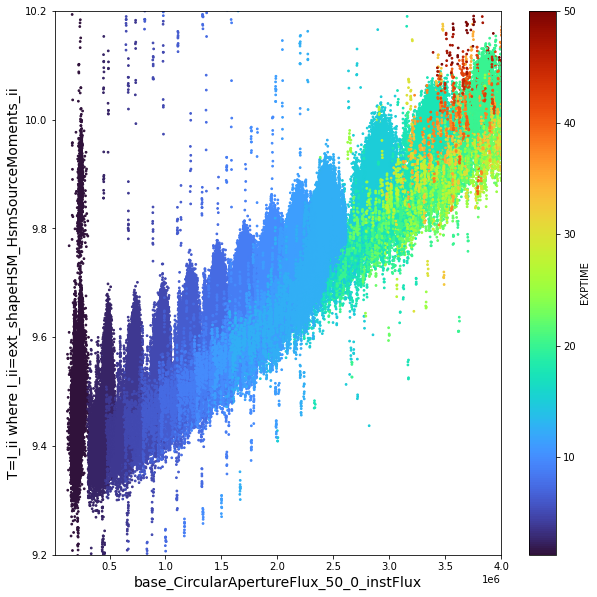

In [30]:
fontsize=14
fig = plt.figure(figsize=(10,10),facecolor="white")

#ykey="ext_shapeHSM_HsmShapeRegauss_sigma"
#ykey="base_SdssShape_xx"
ykey="ext_shapeHSM_HsmSourceMoments_xx"
#y2key="base_SdssShape_yy"
y2key="ext_shapeHSM_HsmSourceMoments_yy"
xkey="base_CircularApertureFlux_50_0_instFlux"
#xkey="base_SdssShape_instFlux"
x = []
y = []
e = []
for aresult in results[:]:
#    cond = ( aresult["src"]["spotgrid_index"]>=0 ) & ( aresult["src"]["spotgrid_normalized_dx"]**2+aresult["src"]["spotgrid_normalized_dy"]**2<0.002**2 )
    cond = ( aresult["src"]["spotgrid_index"]>=0 ) & (aresult["src"]["base_CircularApertureFlux_70_0_instFlux"]>numpy.nanmax(aresult["src"]["base_CircularApertureFlux_70_0_instFlux"])*0.6)
    x.extend(aresult["src"][xkey][cond])
    y.extend((aresult["src"][ykey]+aresult["src"][y2key])[cond])
    e.extend([aresult["md"]["EXPTIME"]]*len(aresult["src"][xkey][cond]))
x=numpy.array(x)
y=numpy.array(y)
plt.scatter(x,y,c=e,s=3,cmap='turbo',alpha=1)
plt.xlabel(xkey,fontsize=fontsize)
plt.ylabel("{}".format("T=I_ii where I_ii=ext_shapeHSM_HsmSourceMoments_ii"),fontsize=fontsize)
plt.xlim(1e4,0.4e7)
plt.ylim(9.2,10.2)
#plt.ylim(1e4,1e8)
plt.colorbar(label="EXPTIME")
#plt.loglog()
#plt.semilogx()


In [31]:
from astropy.table import vstack, join
faint = [ results[i]["src"].asAstropy() for i in  numpy.where(exparray == exptime[2] )[0] ] ### this determines which one from the faintest we are going to base on
mean_data_table = vstack(faint, join_type='exact')

mean_data_table_by_groups = mean_data_table[ numpy.where(
        (mean_data_table["spotgrid_index"]>=0)
    )].group_by('spotgrid_index')
ref = mean_data_table_by_groups.groups.aggregate(numpy.nanmedian)
ref

id,coord_ra,coord_dec,parent,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_SdssCentroid_flag,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxErr,base_SdssShape_yyErr,base_SdssShape_xyErr,base_SdssShape_x,base_SdssShape_y,base_SdssShape_instFlux,base_SdssShape_instFluxErr,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,base_SdssShape_flag,base_SdssShape_flag_unweightedBad,base_SdssShape_flag_unweighted,base_SdssShape_flag_shift,base_SdssShape_flag_maxIter,base_SdssShape_flag_psf,ext_shapeHSM_HsmPsfMoments_x,ext_shapeHSM_HsmPsfMoments_y,ext_shapeHSM_HsmPsfMoments_xx,ext_shapeHSM_HsmPsfMoments_yy,ext_shapeHSM_HsmPsfMoments_xy,ext_shapeHSM_HsmPsfMoments_flag,ext_shapeHSM_HsmPsfMoments_flag_no_pixels,ext_shapeHSM_HsmPsfMoments_flag_not_contained,ext_shapeHSM_HsmPsfMoments_flag_parent_source,ext_shapeHSM_HsmPsfMoments_flag_galsim,ext_shapeHSM_HsmPsfMoments_flag_edge,ext_shapeHSM_HsmShapeBj_e1,ext_shapeHSM_HsmShapeBj_e2,ext_shapeHSM_HsmShapeBj_sigma,ext_shapeHSM_HsmShapeBj_resolution,ext_shapeHSM_HsmShapeBj_flag,ext_shapeHSM_HsmShapeBj_flag_no_pixels,ext_shapeHSM_HsmShapeBj_flag_not_contained,ext_shapeHSM_HsmShapeBj_flag_parent_source,ext_shapeHSM_HsmShapeBj_flag_galsim,ext_shapeHSM_HsmShapeKsb_g1,ext_shapeHSM_HsmShapeKsb_g2,ext_shapeHSM_HsmShapeKsb_sigma,ext_shapeHSM_HsmShapeKsb_resolution,ext_shapeHSM_HsmShapeKsb_flag,ext_shapeHSM_HsmShapeKsb_flag_no_pixels,ext_shapeHSM_HsmShapeKsb_flag_not_contained,ext_shapeHSM_HsmShapeKsb_flag_parent_source,ext_shapeHSM_HsmShapeKsb_flag_galsim,ext_shapeHSM_HsmShapeLinear_e1,ext_shapeHSM_HsmShapeLinear_e2,ext_shapeHSM_HsmShapeLinear_sigma,ext_shapeHSM_HsmShapeLinear_resolution,ext_shapeHSM_HsmShapeLinear_flag,ext_shapeHSM_HsmShapeLinear_flag_no_pixels,ext_shapeHSM_HsmShapeLinear_flag_not_contained,ext_shapeHSM_HsmShapeLinear_flag_parent_source,ext_shapeHSM_HsmShapeLinear_flag_galsim,ext_shapeHSM_HsmShapeRegauss_e1,ext_shapeHSM_HsmShapeRegauss_e2,ext_shapeHSM_HsmShapeRegauss_sigma,ext_shapeHSM_HsmShapeRegauss_resolution,ext_shapeHSM_HsmShapeRegauss_flag,ext_shapeHSM_HsmShapeRegauss_flag_no_pixels,ext_shapeHSM_HsmShapeRegauss_flag_not_contained,ext_shapeHSM_HsmShapeRegauss_flag_parent_source,ext_shapeHSM_HsmShapeRegauss_flag_galsim,ext_shapeHSM_HsmSourceMoments_x,ext_shapeHSM_HsmSourceMoments_y,ext_shapeHSM_HsmSourceMoments_xx,ext_shapeHSM_HsmSourceMoments_yy,ext_shapeHSM_HsmSourceMoments_xy,ext_shapeHSM_HsmSourceMoments_flag,ext_shapeHSM_HsmSourceMoments_flag_no_pixels,ext_shapeHSM_HsmSourceMoments_flag_not_contained,ext_shapeHSM_HsmSourceMoments_flag_parent_source,ext_shapeHSM_HsmSourceMoments_flag_galsim,ext_shapeHSM_HsmSourceMoments_flag_edge,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_instFluxErr,base_CircularApertureFlux_9_0_flag,base_CircularApertureFlux_9_0_flag_apertureTruncated,base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_12_0_instFlux,base_CircularApertureFlux_12_0_instFluxErr

In [32]:
#pylab.scatter(
#    results[0]["src"]["spotgrid_x"],
#    results[0]["src"]["spotgrid_y"]
#)

fig = plt.figure(figsize=(10,10))

for i in range(100):
    pylab.scatter(
        results[i]["src"]["spotgrid_y"],
        results[i]["src"]["spotgrid_x"]
    )

#spotgrid_y	spotgrid_x	spotgrid_normalized_dy	spotgrid_normalized_dx	


NameError: name 'pylab' is not defined

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

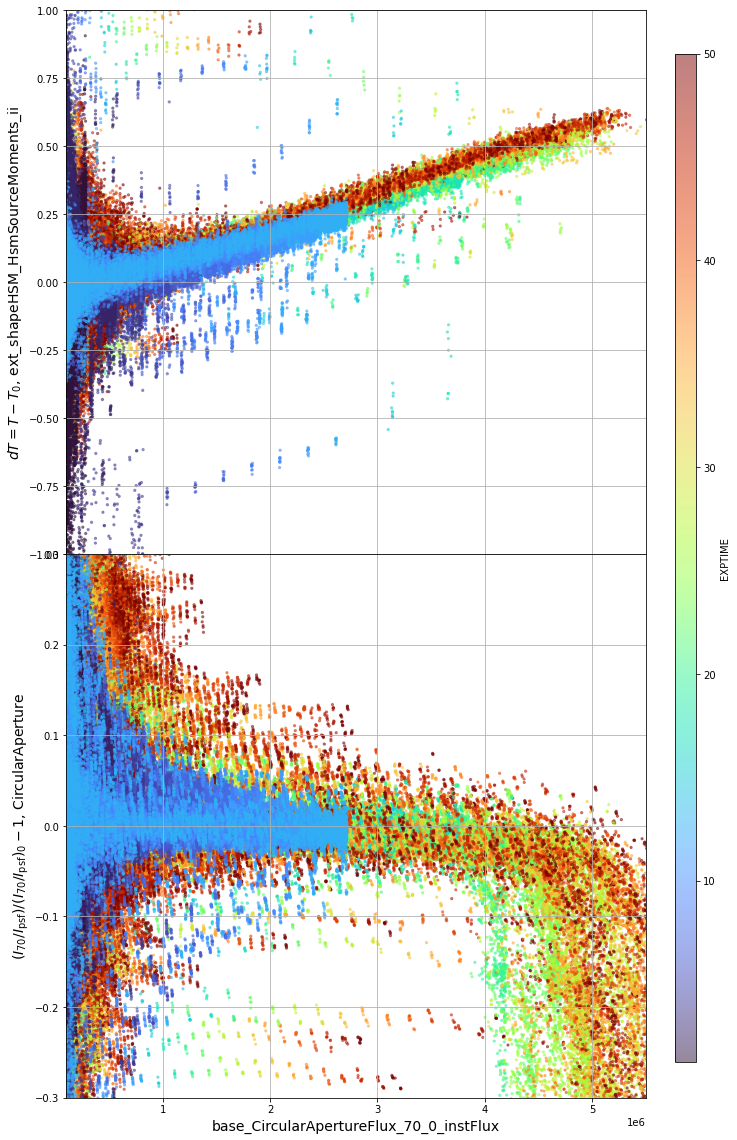

In [36]:
fig = plt.figure(figsize=(10,10),facecolor="white")

from astropy.table import vstack, join

y1key="ext_shapeHSM_HsmSourceMoments_xx"
y2key="ext_shapeHSM_HsmSourceMoments_yy"
#xkey="base_CircularApertureFlux_70_0_instFlux"
xkey="base_CircularApertureFlux_70_0_instFlux"
zskey="base_CircularApertureFlux_3_0_instFlux"
#zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"
# ext_shapeHSM_HsmSourceMoments_xx
  
x = []
y = []
zl = []
zs = []
e = []
for aresult in results[:]:
    joined = join(aresult["src"].asAstropy(),ref,keys="spotgrid_index")
    Iperr = joined["base_PsfFlux_instFluxErr_1"]
    Ip = joined["base_PsfFlux_instFlux_1"]    
    Ierr = joined["{}Err_1".format(xkey)]
    I = joined["{}_1".format(xkey)]
    median=numpy.nanmedian(joined["base_CircularApertureFlux_70_0_instFlux_1"])
    joined = joined[
        numpy.where( 
#            (joined["base_PixelFlags_flag_1"] == False) &
#            (joined["base_PsfFlux_flag_edge_1"] == False) &
#            (joined["base_CircularApertureFlux_70_0_flag_apertureTruncated_1"] == False) &            
#            (joined["base_ClassificationExtendedness_flag_1"] == False) &
#            (joined["base_PixelFlags_flag_1"] == False) &            
#            (joined["base_PixelFlags_flag_offimage_1"] == False) &
#            (joined["base_PixelFlags_flag_edge_1"] == False) &
#            (joined["base_PixelFlags_flag_interpolated_1"] == False) &
#            (joined["base_PixelFlags_flag_saturated_1"] == False) &            
#            (joined["base_PixelFlags_flag_cr_1"] == False) &
#            (joined["base_PixelFlags_flag_bad_1"] == False) &
#            (joined["base_PixelFlags_flag_suspect_1"] == False) &
#            (joined["base_PixelFlags_flag_interpolatedCenter_1"] == False) &
#            (joined["base_PixelFlags_flag_saturatedCenter_1"] == False) &
#            (joined["base_PixelFlags_flag_crCenter_1"] == False) &
#            (joined["base_PixelFlags_flag_suspectCenter_1"] == False) &
            ((joined["base_CircularApertureFlux_70_0_instFlux_1"]-median)/median<0.02)
#            (Iperr/Ip<0.01)&
#            (Ierr/I<0.01)            
        )
    ]
    x.extend(joined["{}_1".format(xkey)])
    Y1=joined["{}_1".format(y1key)]
    Y2=joined["{}_1".format(y2key)]
    Y0_1=joined["{}_2".format(y1key)]
    Y0_2=joined["{}_2".format(y2key)]    
    zl.extend(joined["{}_1".format(zlkey)]/joined["{}_2".format(zlkey)])
    zs.extend(joined["{}_1".format(zskey)]/joined["{}_2".format(zskey)])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([aresult["md"]["EXPTIME"]]*len(Y1))
    
x=numpy.array(x)
y=numpy.array(y)
zl=numpy.array(zl)
zs=numpy.array(zs)

fig = plt.figure(figsize=(10,20),facecolor="white")

ax = plt.subplot(211)
sca=ax.scatter(x,y,c=e,s=5,cmap='turbo',alpha=0.5)
ax.set_ylabel("{}".format(r"$dT=T-T_0$, ext_shapeHSM_HsmSourceMoments_ii"),fontsize=fontsize)
ax.set_xlim(1e5,1e7)
ax.set_ylim(-1,1)
ax.grid()

bx = plt.subplot(212,sharex=ax)
scb=bx.scatter(x,zs/zl-1,c=e,s=5,cmap='turbo',alpha=0.5)
bx.set_ylabel("{}".format(r"$(I_{70}/I_{\rm psf})/(I_{70}/I_{\rm psf})_0-1$, CircularAperture"),fontsize=fontsize)
bx.set_xlim(1e5,0.55e7)
bx.set_ylim(-.3,.3)
#plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.97, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.93,hspace=0)

(array([300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
       404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 4

Text(0.5, 0, 'EXPTIME [s]')

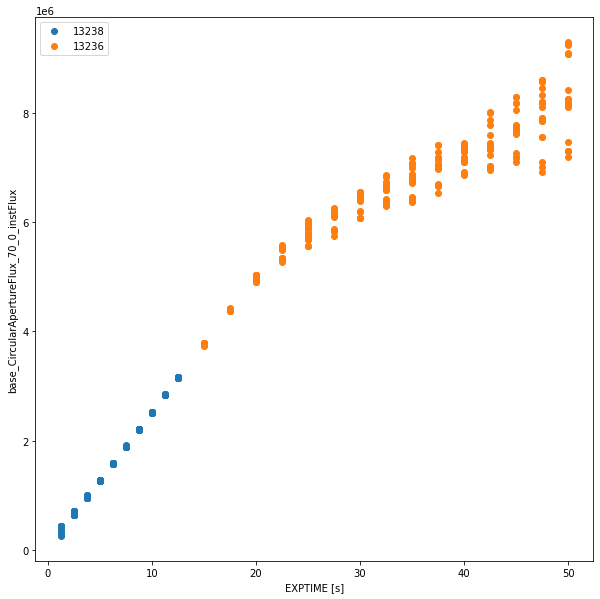

In [34]:
import pylab
fig = plt.figure(figsize=(10,10))

#for a in faint:
peak = []
exp = []
run = []
for b in results:
    peak.append(numpy.nanmax(b["src"]["base_CircularApertureFlux_70_0_instFlux"]))
    exp.append(b["md"]["EXPTIME"])
    run.append(b["md"]["RUNNUM"])

exp=numpy.array(exp)
peak=numpy.array(peak)
run=numpy.array(run)
for arun in list(set(run)):
    print(numpy.where(run == arun))
    pylab.plot(exp[numpy.where(run == arun)],peak[numpy.where(run == arun)],"o",label=arun)
pylab.legend()
pylab.ylabel("base_CircularApertureFlux_70_0_instFlux")
pylab.xlabel("EXPTIME [s]")

In [35]:
where = """
instrument='LSSTCam'
and detector=83
and exposure.observation_type = 'spot'
and exposure.exposure_time = 1.25
and exposure.science_program IN ('13232','13234')
"""

# gridSpotSrc

datasetRefs = list(subregistry.queryDatasets(
    datasetType="postISRCCD",
    collections=collections,
    where=where)
                  )
subresults = []

for aref in datasetRefs[:5]:
    try:
        # get a catalog from the butler
        raw = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
        img = raw.getImage().getArray()
#        print(src.asAstropy()["base_SdssCentroid_x","base_SdssCentroid_y","base_SdssShape_instFlux"])
        md = raw.getMetadata()
        x=src.asAstropy()["spotgrid_x"]
        y=src.asAstropy()["spotgrid_y"]
        I=src.asAstropy()["base_SdssShape_instFlux"]        
        display(raw)
        pylab.title(f"{md['OBSID']} {md['RAFTBAY']}/{md['CCDSLOT']}")
        pylab.plot(x,y,"o")        
        pylab.show()

        print(md["EXPTIME"])
        # stores into memory for later use
        subresults.append( {"md": md, "src":src} )
    except:
#        raise
        pass


In [ ]:
list(md)